In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
import joblib
from time import time

In [38]:
# Carga del dataset de datos preprocesado
df = pd.read_csv('preprocessing_data.csv')
print(len(df))
df.head()

39983


,overall,reviewText,overall_label,processedReview
0,1.0,Deepak Chopra would like to introduce you to J...,1,deepak chopra would like introduce jesus not j...
1,1.0,this games sucks. spend your time on somthing ...,1,game suck spend time somthing else dont buy do...
2,1.0,Don't waste your money. Nothing here you can't...,1,don waste money nothing get free listening rai...
3,1.0,How I wish Amazon would make their own content...,1,how i wish amazon would make content compatibl...
4,1.0,"Moderately interesting plot, but extremely poo...",1,moderately interesting plot extremely poor cop...


In [39]:
# Se dividen los datos en trainy test
X_train, X_test, y_train, y_test = train_test_split(
    df['processedReview'],
    df['overall_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [40]:
X_train.iloc[:10]

25265    play card game often like one getting advice g...
13743    this short story short it advertised seventy-o...
37137    this excellent story great plot excitement rom...
8220     stupid believe i read whole thing hoping would...
35829                                                great
37530                                            good book
11546    in short book complete disaster bit corny the ...
12607    i thought going really good variation went wro...
15601    this author writes style i care i even finish ...
19625    this book really great premise author failed e...
Name: processedReview, dtype: object

In [41]:
y_train.iloc[:10]

25265    0
13743    1
37137    0
8220     1
35829    0
37530    0
11546    1
12607    1
15601    1
19625    1
Name: overall_label, dtype: int64

In [42]:
print(len(X_train))
print(len(X_test))

print(len(y_train))
print(len(y_test))

29987
9996
29987
9996


In [43]:
# Se eliminan valores NaN
X_train = X_train.dropna()
print(len(X_train))

X_test = X_test.dropna()
print(len(X_test))

y_train = y_train.loc[X_train.index]
print(len(y_train))
y_test = y_test.loc[X_test.index]
print(len(y_test))

29985
9994
29985
9994


In [44]:
# Extracción de caracteríasticas con TF-IDF
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=3, strip_accents='ascii')

In [45]:
# Listado de 20 primeras entradas del vocabulario
list(cv.vocabulary_.items())[:20]

[('play', 1637),
 ('card', 298),
 ('game', 921),
 ('often', 1531),
 ('like', 1278),
 ('one', 1539),
 ('getting', 934),
 ('advice', 38),
 ('nice', 1489),
 ('this', 2227),
 ('short', 1982),
 ('story', 2100),
 ('it', 1173),
 ('seventy', 1966),
 ('page', 1577),
 ('but', 274),
 ('reality', 1791),
 ('twenty', 2311),
 ('the', 2211),
 ('rest', 1858)]

In [46]:
len(cv.vocabulary_)

2500

In [47]:
# Se transforman reseñas en matrices numericas
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

In [48]:
words_example = [
    'just',
    'film',
    'very',
    'big',
    'of',
    'that',
    'strange',
    'bad',
    'bouredom',
    'amazing',
    'bore',
    'stupid'
]

In [49]:
# Se crea un diccionario que asigna cada palabra en el vocabulario a su valor IDF correspondiente
vocab_idf = dict(zip(cv.get_feature_names_out(), cv.idf_))

# Se calcula y muestra los valores IDF (Inverse Document Frequency) de un conjunto de palabras
print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))


Palabra             IDF                 
just                4.779
film                7.074
very                4.342
big                 4.800
of                  5.400
that                4.389
strange             5.952
bad                 4.069
bouredom            OOV                 
amazing             5.068
bore                OOV                 
stupid              5.649


In [50]:
# Se selecciona una muestra aleatoria de los datos de entrenamiento y se imprime en la salida
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 8921
Sentiment: 1
Review: not much fun i thought would would recommend game sorry i got game


In [51]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names_out(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 8921:
              tfidf
game       0.580286
would      0.371605
sorry      0.354567
fun        0.288733
got        0.266691
not        0.262293
recommend  0.256143
thought    0.252665
much       0.216153

Top 10 words with lowest TF_IDF in the review 8921:
              tfidf
game       0.580286
would      0.371605
sorry      0.354567
fun        0.288733
got        0.266691
not        0.262293
recommend  0.256143
thought    0.252665
much       0.216153


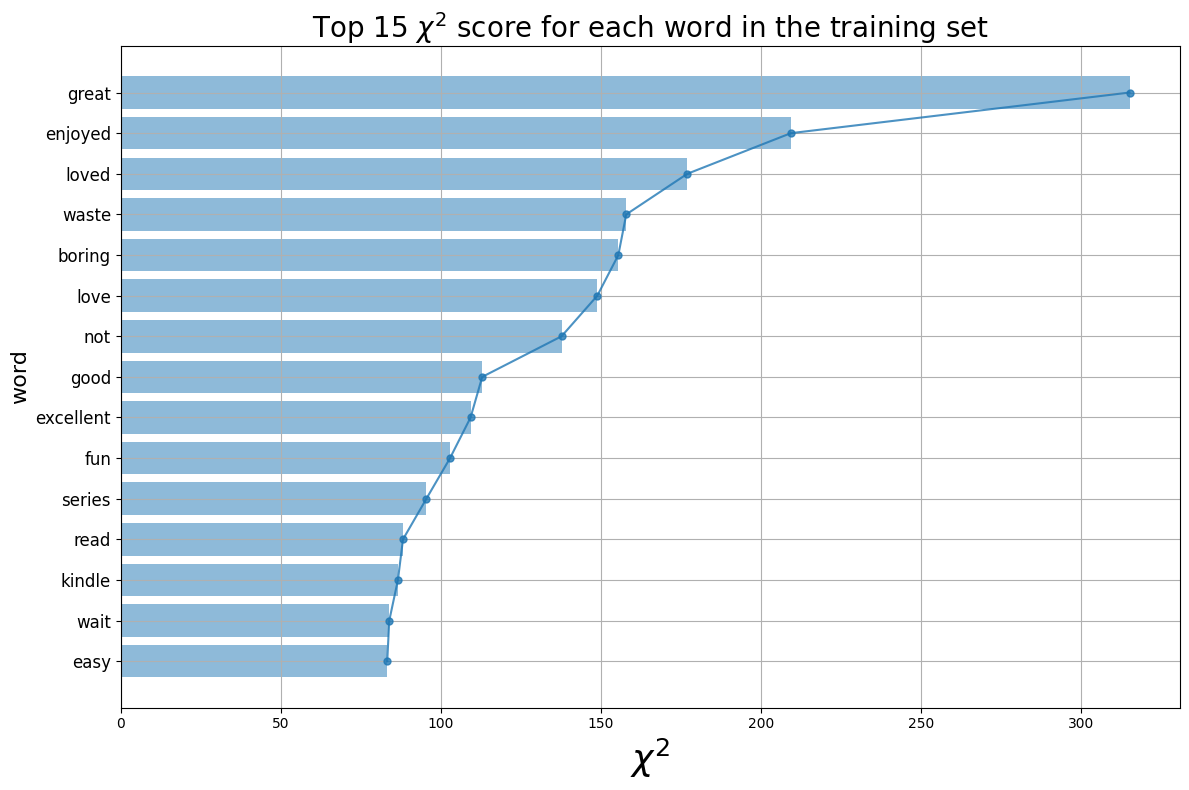

In [52]:
# Se calcula el chi2 para un conjunto de características
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

## MODELO DE REGRESIÓN LOGISTICA

In [54]:
# Se entrenan los modelos para Regresión Logistica
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

t = time()

train_acc = list()
test_acc = list()

best_accuracy_lr = 0.0
best_model_lr = None

for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)

    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

    # Se selecciona el mejor modelo según accuracy
    if accuracy_score(y_test, test_predict) > best_accuracy_lr:
        best_accuracy = accuracy_score(y_test, test_predict)
        best_model_lr = lr

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

# Guardar el modelo con el parámetro de c de mejor rendimiento
if best_model_lr is not None:
    joblib.dump(best_model_lr, 'best_model_lr.pkl')

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Accuracy for C=0.01: 0.8221933159895938
Accuracy for C=0.05: 0.8488092855713428
Accuracy for C=0.25: 0.8621172703622173
Accuracy for C=0.5: 0.8670202121272763
Accuracy for C=1: 0.8665199119471683
Accuracy for C=10: 0.8622173303982389
Accuracy for C=100: 0.8578146888132879
Accuracy for C=1000: 0.8559135481288773
Accuracy for C=10000: 0.8556133680208124
Time to train the model: 0.13 mins


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
# Se carga el modelo para comprobar las métricas
loaded_model_lr = joblib.load('best_model_lr.pkl')

In [56]:
test_predict_loaded_lr = loaded_model_lr.predict(X_test_)

In [57]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict_loaded_lr)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict_loaded_lr)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict_loaded_lr)))

# Se puedes concluir que el modelo tiene un rendimiento sólido y equilibrado en ambas clases, con una precisión global decente,
# aunque hay un número considerable de falsos positivos y falsos negativos

Confussion matrix:
[[4277  731]
 [ 712 4274]]

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      5008
           1       0.85      0.86      0.86      4986

    accuracy                           0.86      9994
   macro avg       0.86      0.86      0.86      9994
weighted avg       0.86      0.86      0.86      9994

Accuracy score:0.8556133680208124


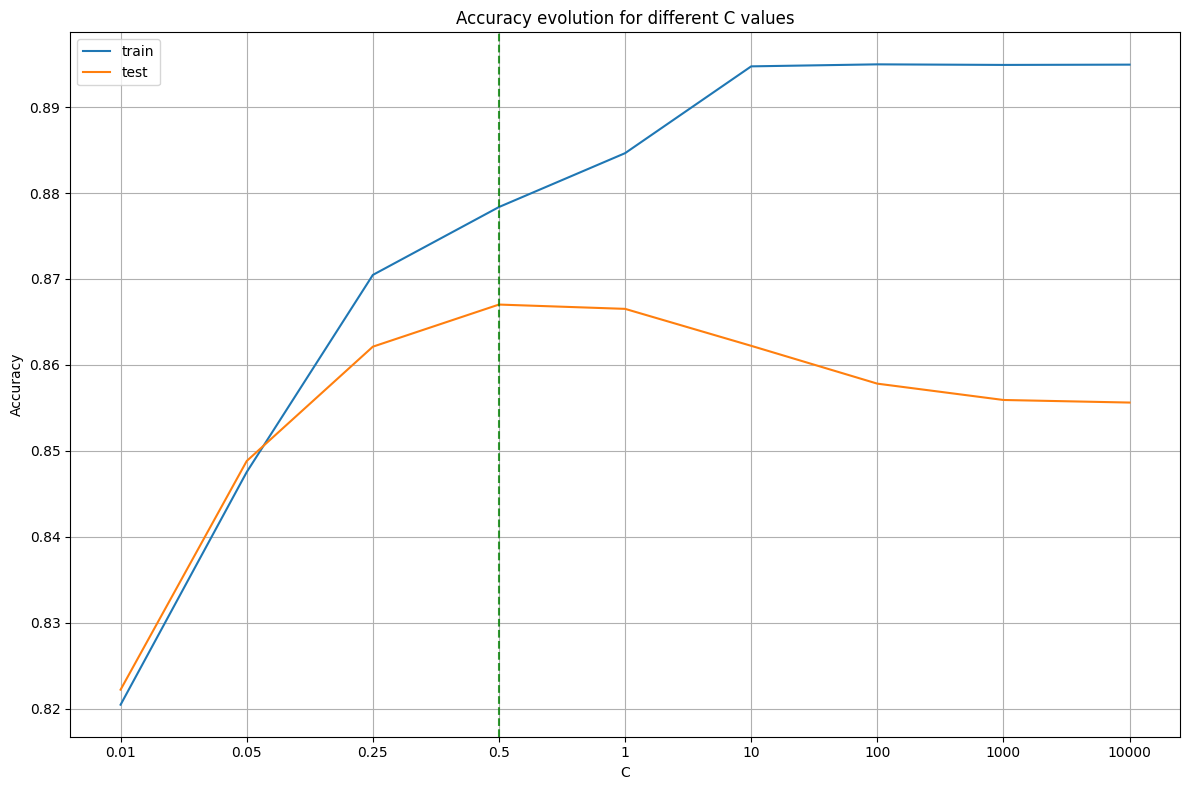

In [58]:
# Se grafica la evolucion del accuracy del modelo a medida que cabia el parámetro C
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [59]:
# Se calcula las curvas de precisión y recuperación (recall) en función de diferentes umbrales para un modelo de clasificación
p, r, thresholds = precision_recall_curve(y_test, test_predict_loaded_lr)

In [60]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
     Traza las puntuaciones de precisión y recuperación en función del umbral de decisión para un modelo de clasificación.

     Parámetros:
         precisions (tipo matriz): lista de puntuaciones de precisión calculadas para diferentes umbrales.
         recalls (en forma de matriz): lista de puntajes de recalls calculados para diferentes umbrales.
         thresholds (tipo matriz): lista de umbrales de decisión correspondientes a puntuaciones de precisión y recuperación.

     Retorna:
         Ninguno (muestra la trama)
     """

    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

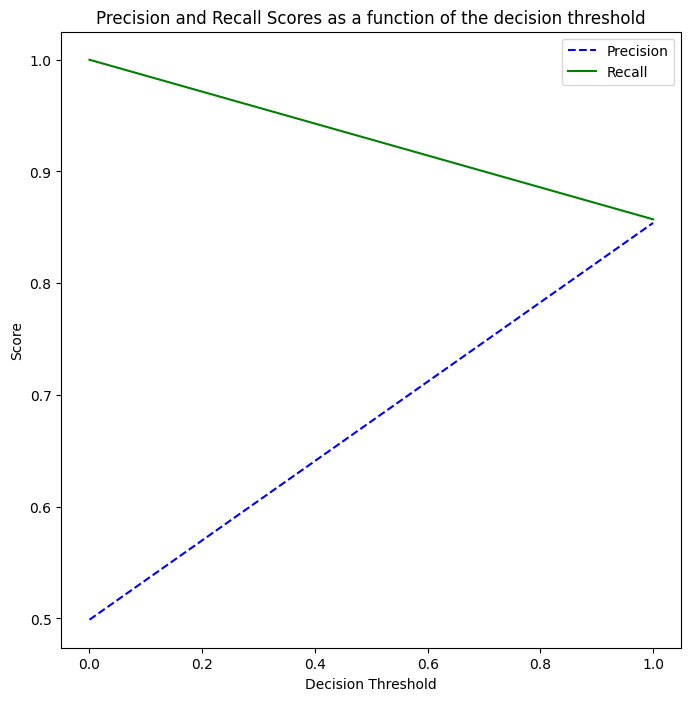

In [61]:
plot_precision_recall_vs_threshold(p, r, thresholds)

In [62]:
def predict_review_sentiment(review_index, model):
    """
    Predice el sentimiento de una review utilizando un modelo de clasificación entrenado.

    Parámetros:
        indice_revision (int): Índice de la review en el conjunto de datos.
        modelo: Modelo de clasificación entrenado (por ejemplo, LogisticRegression).

    Retorna:
        None (imprime el sentimiento real y el sentimiento predicho)
    """
    print('Actual sentiment: {}'.format(df.iloc[review_index]['overall_label']))
    r = df.iloc[review_index]['processedReview']
    print('Prediction: {}'.format(model.predict(cv.transform([r]))))

In [63]:
# Se predecice y muestra el sentimiento de 10 reviews seleccionadas al azar
random.seed(42)

for i in random.sample(range(0, len(df)), 10):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, loaded_model_lr)


Review no. 7296
Actual sentiment: 1
Prediction: [1]

Review no. 1639
Actual sentiment: 1
Prediction: [1]

Review no. 18024
Actual sentiment: 1
Prediction: [0]

Review no. 16049
Actual sentiment: 1
Prediction: [1]

Review no. 14628
Actual sentiment: 1
Prediction: [1]

Review no. 9144
Actual sentiment: 1
Prediction: [0]

Review no. 6717
Actual sentiment: 1
Prediction: [1]

Review no. 35741
Actual sentiment: 0
Prediction: [0]

Review no. 5697
Actual sentiment: 1
Prediction: [1]

Review no. 38698
Actual sentiment: 0
Prediction: [0]


## MODELO DE GBOOST

In [65]:
n_estimators = [8, 16, 32, 64, 128, 256, 512, 1024]

t = time()

acc_train = list()
acc_test = list()

best_accuracy_clf = 0.0
best_model_clf = None

for n in n_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, learning_rate=1.0, max_depth=1, random_state=42)

    clf.fit(X_train_, y_train)

    pred_train = clf.predict(X_train_)
    pred_test = clf.predict(X_test_)

    acc_train.append(accuracy_score(y_train, pred_train))
    acc_test.append(accuracy_score(y_test, pred_test))

    if accuracy_score(y_test, pred_test) > best_accuracy_clf:
        best_accuracy_clf = accuracy_score(y_test, pred_test)
        best_model_clf = clf

    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train_, y_train),
            clf.score(X_test_, y_test)))

# Guardar el modelo con el mejor rendimiento
if best_model_clf is not None:
    joblib.dump(best_model_clf, 'best_model_clf.pkl')

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

[GradientBoostingClassifier] Accuracy: train = 0.6680673670168418, test = 0.6764058435061037
[GradientBoostingClassifier] Accuracy: train = 0.7174920793730198, test = 0.7204322593556134
[GradientBoostingClassifier] Accuracy: train = 0.7518759379689844, test = 0.7526515909545728
[GradientBoostingClassifier] Accuracy: train = 0.7862597965649492, test = 0.7844706824094456
[GradientBoostingClassifier] Accuracy: train = 0.8200433550108388, test = 0.8154892935761456
[GradientBoostingClassifier] Accuracy: train = 0.8514257128564282, test = 0.836101660996598
[GradientBoostingClassifier] Accuracy: train = 0.8801400700350175, test = 0.842805683410046
[GradientBoostingClassifier] Accuracy: train = 0.9098215774553944, test = 0.8420052031218731
Time to train the model: 4.15 mins


In [66]:
print(best_model_clf)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, n_estimators=512,
                           random_state=42)


In [67]:
if best_model_clf is not None:
    joblib.dump(best_model_clf, 'best_model_clf.pkl')

In [68]:
loaded_model_clf = joblib.load('best_model_clf.pkl')

In [69]:
pred_test_loaded_clf = loaded_model_clf.predict(X_test_)

In [70]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, pred_test_loaded_clf)))
print('\nClassification report:\n{}'.format(classification_report(y_test, pred_test_loaded_clf)))
print('Accuracy score:{}'.format(accuracy_score(y_test, pred_test_loaded_clf)))

# Se  el modelo GradientBoostingClassifier está obteniendo resultados bastante consistentes entre ambas clases.
# Aunque la precisión y el recall son similares para ambas clases, hay un pequeño desequilibrio, ya que el modelo
# parece tener un rendimiento ligeramente mejor en la clase 0

Confussion matrix:
[[4187  821]
 [ 750 4236]]

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      5008
           1       0.84      0.85      0.84      4986

    accuracy                           0.84      9994
   macro avg       0.84      0.84      0.84      9994
weighted avg       0.84      0.84      0.84      9994

Accuracy score:0.842805683410046


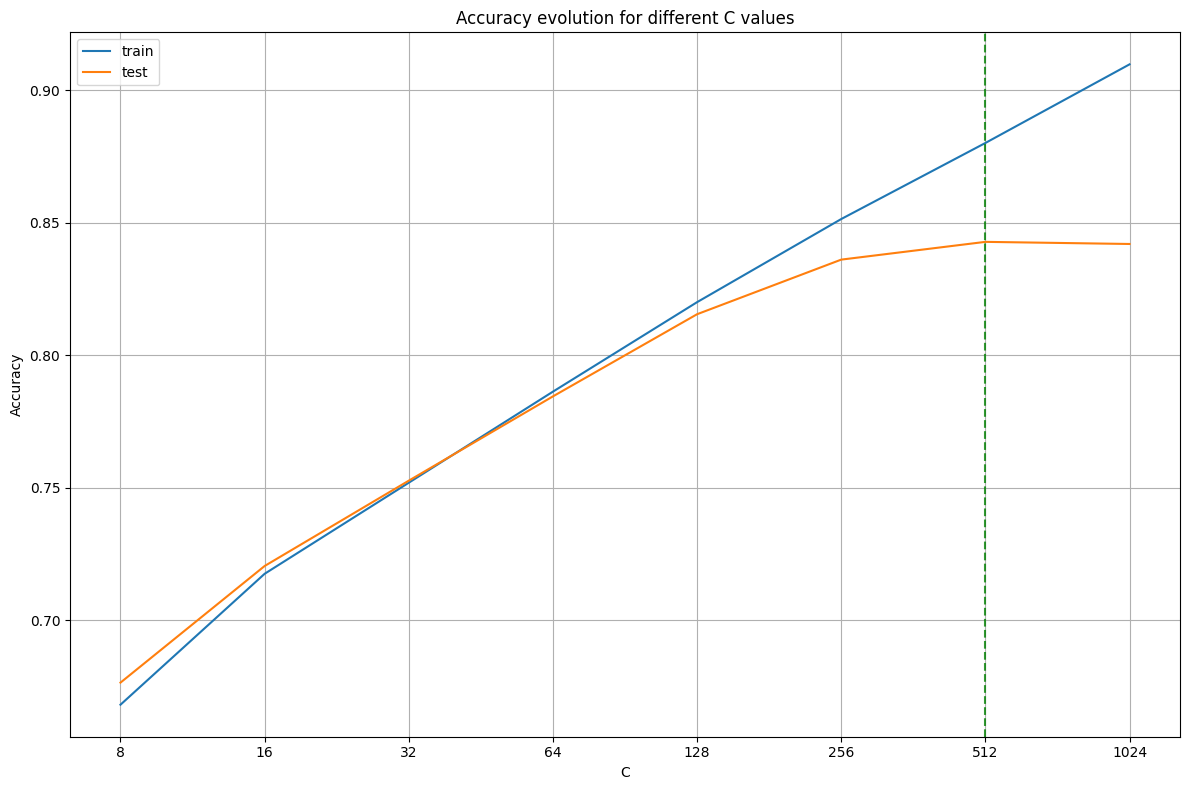

In [71]:
plt.figure(figsize=(12, 8))
plt.plot(acc_train, label='train')
plt.plot(acc_test, label='test')
plt.axvline(np.argmax(acc_test), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(n_estimators))), n_estimators)
plt.tight_layout()
plt.show()

In [72]:
p, r, thresholds = precision_recall_curve(y_test, pred_test_loaded_clf)

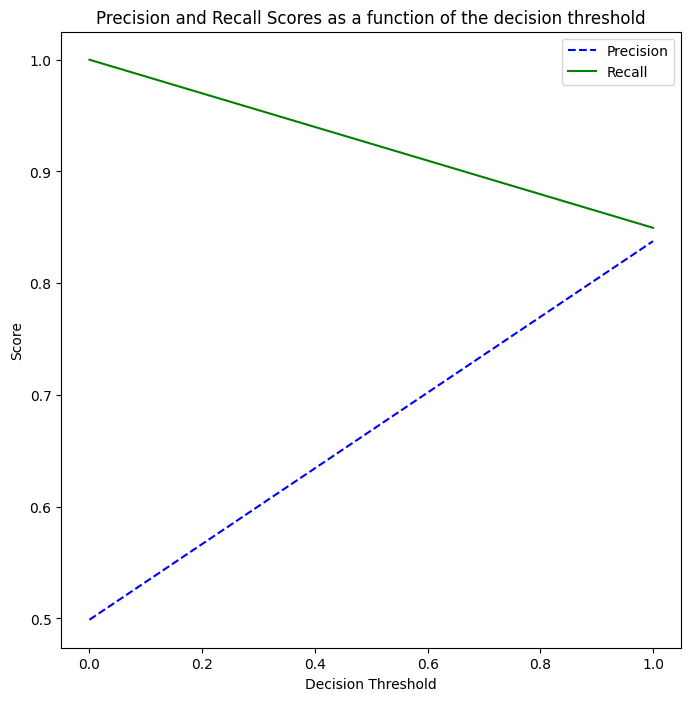

In [73]:
plot_precision_recall_vs_threshold(p, r, thresholds)

In [76]:
# Se predecice y muestra el sentimiento de 10 reviews seleccionadas al azar
random.seed(42)

for i in random.sample(range(0, len(df)), 10):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, loaded_model_clf)


Review no. 7296
Actual sentiment: 1
Prediction: [1]

Review no. 1639
Actual sentiment: 1
Prediction: [1]

Review no. 18024
Actual sentiment: 1
Prediction: [0]

Review no. 16049
Actual sentiment: 1
Prediction: [1]

Review no. 14628
Actual sentiment: 1
Prediction: [1]

Review no. 9144
Actual sentiment: 1
Prediction: [0]

Review no. 6717
Actual sentiment: 1
Prediction: [1]

Review no. 35741
Actual sentiment: 0
Prediction: [0]

Review no. 5697
Actual sentiment: 1
Prediction: [1]

Review no. 38698
Actual sentiment: 0
Prediction: [0]


## CONCLUSIÓN COMPARATIVA ENTRE AMBOS MODELOS

Comparando los resultados de los dos modelos, la Regresión Logística y el GradientBoostingClassifier, podemos hacer las siguientes comparaciones:

Accuracy: La Regresión Logística tiene una precisión general ligeramente mejor (0.856) en comparación con el GradientBoostingClassifier (0.843).
Esto significa que el modelo de Regresión Logística clasifica correctamente un poco más de instancias en comparación con el modelo de GradientBoostingClassifier.

Precision y Recall: Ambos modelos tienen métricas de precisión y recall muy similares para ambas clases. La precisión y el recall para ambas clases están en el
rango de 0.84-0.86 para ambos modelos.

F1-score: El F1-score es similar en ambos modelos, alrededor de 0.84-0.86 para ambas clases.

Tiempo de entrenamiento. Existe una diferencia significativa enntre ambos modelos. Mientras que la Regresión Logística tardó 0.13 minutos en
GradientBoostingClassifier el entrenamiento duró 4.15 minutos.

En general, ambos modelos muestran resultados comparables y muy cercanos en términos de métricas de rendimiento. Los timpos aunque son dediferencia significativa
entr si, en terminos generales no son nada elevados. Con apenas 10000 muestras se han obtenido resultados mu buenos, lo que es un indicativo de la sencillez en
complejidad del modelo. Entre hambos modelos nos quedaíamos con la Regresión Logística porque tarda menos y los resultados son ligeramente mejores.